## Exploratory Data Analysis

In [71]:
import matplotlib.pyplot as plt
import pydicom
from pydicom.pixel_data_handlers.util import apply_modality_lut
import numpy as np
import scipy.ndimage
from skimage import morphology
from skimage import measure
from skimage.transform import resize
from sklearn.cluster import KMeans
import pandas as pd
import os

data_path = '/Users/ryanlussier/ICH Detection and Classification/data/'



In [117]:
directory = os.fsencode(data_path)

ids = []
scans = []
images = []

for file in os.listdir(directory):
    filename = os.fsdecode(file)
    if filename.endswith(".dcm"):
        ds = pydicom.dcmread(data_path + filename)
        ids.append(filename.split('.')[0])
        scans.append(ds)
        images.append(ds.pixel_array)
        #plt.imshow(ds.pixel_array, cmap=plt.cm.bone)
        continue
    else:
        continue


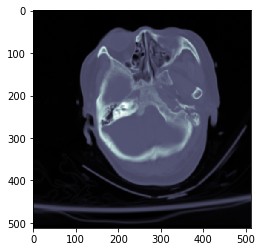

In [190]:
demo_scan = scans[15]
plt.imshow(demo_scan.pixel_array, cmap=plt.cm.bone)

In [192]:
demo_scan

Dataset.file_meta -------------------------------
(0002, 0000) File Meta Information Group Length  UL: 176
(0002, 0001) File Meta Information Version       OB: b'\x00\x01'
(0002, 0002) Media Storage SOP Class UID         UI: CT Image Storage
(0002, 0003) Media Storage SOP Instance UID      UI: 9999.238806058494015810637175892458903833803
(0002, 0010) Transfer Syntax UID                 UI: Explicit VR Little Endian
(0002, 0012) Implementation Class UID            UI: 1.2.40.0.13.1.1.1
(0002, 0013) Implementation Version Name         SH: 'dcm4che-1.4.38'
-------------------------------------------------
(0008, 0018) SOP Instance UID                    UI: ID_2baac3f47
(0008, 0060) Modality                            CS: 'CT'
(0010, 0020) Patient ID                          LO: 'ID_5dd962d3'
(0020, 000d) Study Instance UID                  UI: ID_0973ecd0cc
(0020, 000e) Series Instance UID                 UI: ID_3283f2e9a8
(0020, 0010) Study ID                            SH: ''
(0020, 00

In [198]:
hu_list = []
hu_ids = []
for scan in scans:
    hu_list.append(apply_modality_lut(scan.pixel_array, scan))
    hu_ids.append(scan.SOPInstanceUID)
hu_df = pd.DataFrame(list(zip(hu_ids, hu_list)), columns=['ID', 'image_array'])
hu_df.head()

,ID,image_array
0,ID_5f3ae54bb,"[[-2048.0, -2048.0, -2048.0, -2048.0, -2048.0,..."
1,ID_5f3e2bd5c,"[[-1000.0, -1000.0, -1002.0, -1003.0, -1003.0,..."
2,ID_5f3d214ca,"[[-1010.0, -1009.0, -1009.0, -1008.0, -1008.0,..."
3,ID_5f4d9918c,"[[-3024.0, -3024.0, -3024.0, -3024.0, -3024.0,..."
4,ID_5f4a079bb,"[[-3024.0, -3024.0, -3024.0, -3024.0, -3024.0,..."


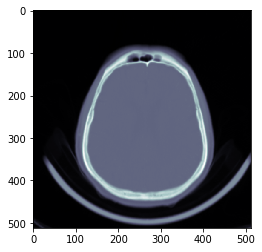

In [186]:
plt.imshow(hu_list[51], cmap=plt.cm.bone)

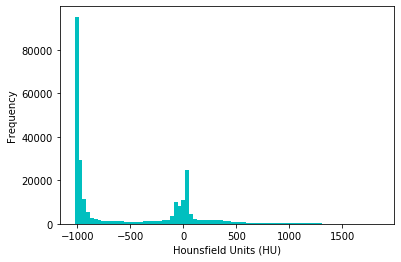

In [83]:
plt.hist(hu.flatten(), bins=80, color='c')
plt.xlabel("Hounsfield Units (HU)")
plt.ylabel("Frequency")
plt.show()

# Show some slice in the middle
#plt.imshow(first_patient_pixels[80], cmap=plt.cm.gray)
#plt.show()

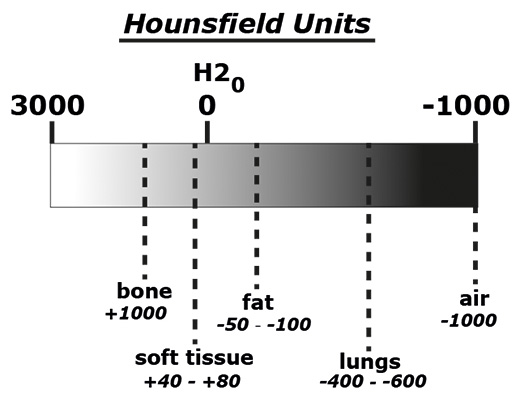

In [63]:
# image from: https://www.startradiology.com/internships/neurology/brain/ct-brain-hemorrhage/
# need to check license...
from IPython.display import Image
Image(filename='/Users/ryanlussier/ICH Detection and Classification/images/english-class-ct-brain-hemorrhage-fig1-hounsfield-unit.jpg') 
#plt.imshow()

In [ ]:
# resample pixel spacing to be consistent (1, 1) if needed
# segmentation (if needed)
# normalization
# zero centering


In [38]:

training_df = pd.read_csv(data_path + 'stage_2_train.csv')
training_df[['ID', 'Subtype']] = training_df.ID.str.rsplit(pat='_', expand=True, n=1)

In [39]:
training_df.head(10)

,ID,Label,Subtype
0,ID_12cadc6af,0,epidural
1,ID_12cadc6af,0,intraparenchymal
2,ID_12cadc6af,0,intraventricular
3,ID_12cadc6af,0,subarachnoid
4,ID_12cadc6af,0,subdural
5,ID_12cadc6af,0,any
6,ID_38fd7baa0,0,epidural
7,ID_38fd7baa0,0,intraparenchymal
8,ID_38fd7baa0,0,intraventricular
9,ID_38fd7baa0,0,subarachnoid


In [219]:
training_df.groupby(by=['Subtype']).sum()

,Label
Subtype,
any,107933
epidural,3145
intraparenchymal,36118
intraventricular,26205
subarachnoid,35675
subdural,47166


In [40]:
# Let's see how many patients are in the training set
training_df.ID.nunique()

752803

In [41]:
# Do any patient ID's occur more than once?
training_df.ID.value_counts().head(10)

ID_854fba667    12
ID_a64d5deed    12
ID_921490062    12
ID_489ae4179    12
ID_37f487592     6
ID_723292347     6
ID_a7d8a913c     6
ID_d434405bb     6
ID_14252b682     6
ID_4943b0035     6
Name: ID, dtype: int64

## this also shows us that there are likely some duplicate entries

In [175]:
dupes = training_df[training_df.duplicated(keep=False)]
dupes.head()

,ID,Label,Subtype


In [161]:
training_df = training_df.drop_duplicates()
train_pivot = training_df.pivot(index='ID', columns='Subtype', values='Label')

In [162]:
col_names = train_pivot.columns.values.tolist()
train_pivot['Y_vals'] = train_pivot[col_names].to_numpy().tolist()
train_pivot.iloc[14:25]

Subtype,any,epidural,intraparenchymal,intraventricular,subarachnoid,subdural,Y_vals
ID,,,,,,,
ID_0002081b6,1,0,1,0,0,0,"[1, 0, 1, 0, 0, 0]"
ID_0002108bd,0,0,0,0,0,0,"[0, 0, 0, 0, 0, 0]"
ID_000229f2a,0,0,0,0,0,0,"[0, 0, 0, 0, 0, 0]"
ID_000230ed7,0,0,0,0,0,0,"[0, 0, 0, 0, 0, 0]"
ID_000259ccf,0,0,0,0,0,0,"[0, 0, 0, 0, 0, 0]"
ID_00025ef4b,0,0,0,0,0,0,"[0, 0, 0, 0, 0, 0]"
ID_000270f8b,0,0,0,0,0,0,"[0, 0, 0, 0, 0, 0]"
ID_00027c277,0,0,0,0,0,0,"[0, 0, 0, 0, 0, 0]"
ID_00027cbb1,0,0,0,0,0,0,"[0, 0, 0, 0, 0, 0]"


In [163]:
train_Y = train_pivot.Y_vals
train_Y.head()

ID
ID_000012eaf    [0, 0, 0, 0, 0, 0]
ID_000039fa0    [0, 0, 0, 0, 0, 0]
ID_00005679d    [0, 0, 0, 0, 0, 0]
ID_00008ce3c    [0, 0, 0, 0, 0, 0]
ID_0000950d7    [0, 0, 0, 0, 0, 0]
Name: Y_vals, dtype: object

In [206]:
train_Y_sub = train_Y[ids]

mod_df = pd.merge(hu_df, train_Y_sub, how='left', left_on='ID', right_index=True)

mod_df.to_pickle(data_path + 'mod_df.pickle')





In [42]:
# Let's take a look at the labels to see if the data is balanced
training_df.Label.value_counts()

0    4260600
1     256242
Name: Label, dtype: int64

## As suspected, the data is not balanced with hemorrhages occuring very rarely.

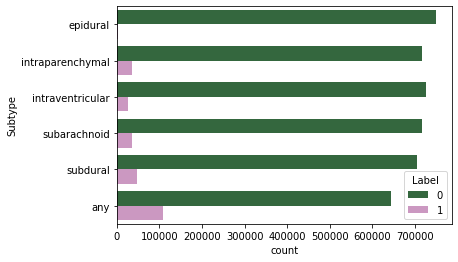

In [43]:
import seaborn as sns

ax = sns.countplot(y="Subtype", hue='Label', data=training_df, palette='cubehelix')

In [47]:
training_df[training_df.Label == 1].head()

,ID,Label,Subtype
21,ID_aec8e68b3,1,subarachnoid
23,ID_aec8e68b3,1,any
57,ID_ff7125125,1,subarachnoid
59,ID_ff7125125,1,any
115,ID_9b7d000a2,1,intraparenchymal


In [ ]:
'''
Substance	HU
Air	−1000
Lung	−500
Fat	−100 to −50
Water	0
Blood	+30 to +70
Muscle	+10 to +40
Liver	+40 to +60
Bone	+700 (cancellous bone) to +3000 (cortical bone)
'''

In [102]:
# display image array
#id = 0
#imgs_to_process = np.load(directory_in_str+'fullimages_{}.npy'.format(id))

def sample_stack(stack, rows=6, cols=6, start_with=10, show_every=5):
    fig,ax = plt.subplots(rows,cols,figsize=[12,12])
    for i in range(rows*cols):
        ind = start_with + i*show_every
        ax[int(i/rows),int(i % rows)].set_title('scan %d' % ind)
        ax[int(i/rows),int(i % rows)].imshow(stack[ind],cmap='gray')
        ax[int(i/rows),int(i % rows)].axis('off')
    plt.show()

#sample_stack(imgs_to_process)

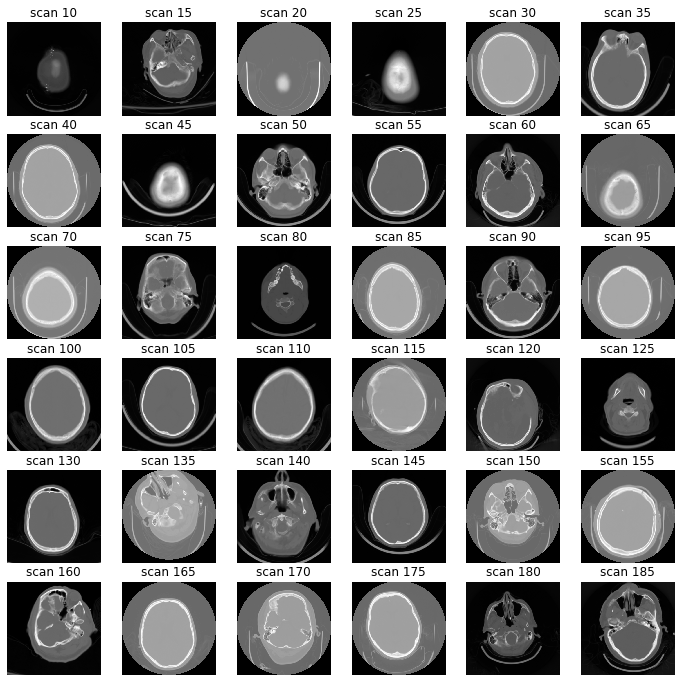

In [103]:
sample_stack(images)

In [ ]:
id = 0
imgs_to_process = np.load(output_path+'fullimages_{}.npy'.format(id))
def resample(image, scan, new_spacing=[1,1,1]):
    # Determine current pixel spacing
    spacing = map(float, ([scan[0].SliceThickness] + scan[0].PixelSpacing))
    spacing = np.array(list(spacing))

    resize_factor = spacing / new_spacing
    new_real_shape = image.shape * resize_factor
    new_shape = np.round(new_real_shape)
    real_resize_factor = new_shape / image.shape
    new_spacing = spacing / real_resize_factor
    
    image = scipy.ndimage.interpolation.zoom(image, real_resize_factor)
    
    return image, new_spacing

print "Shape before resampling\t", imgs_to_process.shape
imgs_after_resamp, spacing = resample(imgs_to_process, patient, [1,1,1])
print "Shape after resampling\t", imgs_after_resamp.shape

In [132]:
#Standardize the pixel values
def make_lungmask(img, display=False):
    row_size= img.shape[0]
    col_size = img.shape[1]
    
    mean = np.mean(img)
    std = np.std(img)
    img = img-mean
    img = img/std
    # Find the average pixel value near the lungs
    # to renormalize washed out images
    middle = img[int(col_size/5):int(col_size/5*4),int(row_size/5):int(row_size/5*4)] 
    mean = np.mean(middle)  
    max = np.max(img)
    min = np.min(img)
    # To improve threshold finding, I'm moving the 
    # underflow and overflow on the pixel spectrum
    img[img==max]=mean
    img[img==min]=mean
    #
    # Using Kmeans to separate foreground (soft tissue / bone) and background (lung/air)
    #
    kmeans = KMeans(n_clusters=2).fit(np.reshape(middle,[np.prod(middle.shape),1]))
    centers = sorted(kmeans.cluster_centers_.flatten())
    threshold = np.mean(centers)
    thresh_img = np.where(img<threshold,1.0,0.0)  # threshold the image

    # First erode away the finer elements, then dilate to include some of the pixels surrounding the lung.  
    # We don't want to accidentally clip the lung.

    eroded = morphology.erosion(thresh_img,np.ones([3,3]))
    dilation = morphology.dilation(eroded,np.ones([8,8]))

    labels = measure.label(dilation) # Different labels are displayed in different colors
    label_vals = np.unique(labels)
    regions = measure.regionprops(labels)
    good_labels = []
    for prop in regions:
        B = prop.bbox
        if B[2]-B[0]<row_size/10*9 and B[3]-B[1]<col_size/10*9 and B[0]>row_size/5 and B[2]<col_size/5*4:
            good_labels.append(prop.label)
    mask = np.ndarray([row_size,col_size],dtype=np.int8)
    mask[:] = 0

    #
    #  After just the lungs are left, we do another large dilation
    #  in order to fill in and out the lung mask 
    #
    for N in good_labels:
        mask = mask + np.where(labels==N,1,0)
    mask = morphology.dilation(mask,np.ones([10,10])) # one last dilation

    if (display):
        fig, ax = plt.subplots(3, 2, figsize=[12, 12])
        ax[0, 0].set_title("Original")
        ax[0, 0].imshow(img, cmap='gray')
        ax[0, 0].axis('off')
        ax[0, 1].set_title("Threshold")
        ax[0, 1].imshow(thresh_img, cmap='gray')
        ax[0, 1].axis('off')
        ax[1, 0].set_title("After Erosion and Dilation")
        ax[1, 0].imshow(dilation, cmap='gray')
        ax[1, 0].axis('off')
        ax[1, 1].set_title("Color Labels")
        ax[1, 1].imshow(labels)
        ax[1, 1].axis('off')
        ax[2, 0].set_title("Final Mask")
        ax[2, 0].imshow(mask, cmap='gray')
        ax[2, 0].axis('off')
        ax[2, 1].set_title("Apply Mask on Original")
        ax[2, 1].imshow(mask*img, cmap='gray')
        ax[2, 1].axis('off')
        
        plt.show()
    return mask*img

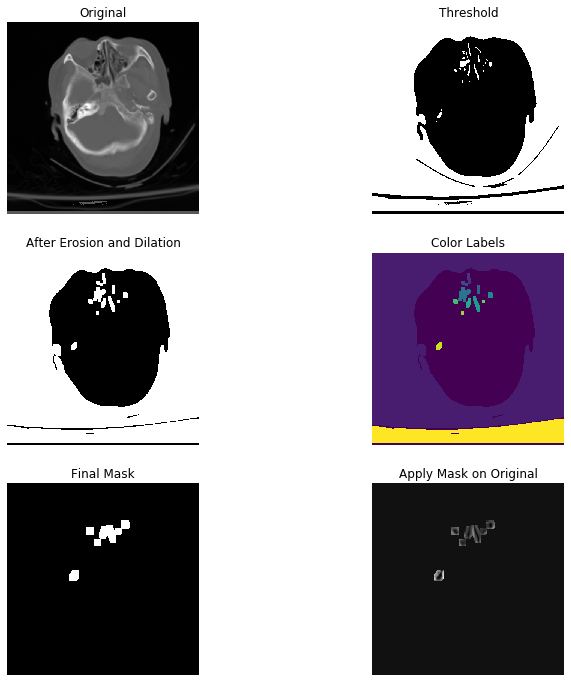

array([[-0., -0., -0., ..., -0., -0., -0.],
       [-0., -0., -0., ..., -0., -0., -0.],
       [-0., -0., -0., ..., -0., -0., -0.],
       ...,
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.]])

In [131]:
make_lungmask(hu, display=True)